# Predicting age from brain structures
<img src="images/BrainVolumes.png" width = "300" style="float: right;"> 

In this notebook we will apply what we learned this week to our example of prediction of age of a baby from the volumes of brain structures. We will learn how to tune the parameters of the network and design a non-linear solution.

First, we will load the dataset of 86 brain volumes and convert the feature matrix and target vector to tensors. Run the cell below to load the dataset with 86 structures.

In [1]:
# only do this if you work on Google Colab
# run the cell
# then upload file 'GA-brain-volumes-86-features.csv'

#from google.colab import files
#files.upload()

In [2]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def CreateFeaturesTargets(filename):
    
    df = pd.read_csv(filename,header=None)
    
    # convert from 'DataFrame' to numpy array
    data = df.values

    # Features are in columns one to end
    X = data[:,1:]
    
    # Scale features
    X = StandardScaler().fit_transform(X)

    # Labels are in the column zero
    y = data[:,0].reshape(-1,1)

    # return Features and Labels
    return X, y

X,y = CreateFeaturesTargets('GA-brain-volumes-86-features.csv')

# perform scaling of the target values to support better convergence
target_scaler = StandardScaler()
y = target_scaler.fit_transform(y)

print('Number of samples is', X.shape[0])
print('Number of features is', X.shape[1])

# convert to tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X type: ', X.type())
print('y type: ', y.type())

Number of samples is 164
Number of features is 86
X shape:  torch.Size([164, 86])
y shape:  torch.Size([164, 1])
X type:  torch.FloatTensor
y type:  torch.FloatTensor


**Note 1:** We have converted the target values to a two dimensional vector and both feature matrix and target vector are Pytorch tensors of type `float`. This is required by Pytorch.

**Note 2:** Unlike before we performed scaling of the target values as well. This improves convergence of stochastic gradient descent (regression techniques we used before used analytical solutions or different optimisers)

Below is the function `PlotTargets` that we used before to display true and predicted target values. Take a note of the function and run the cell.

In [3]:
import matplotlib.pyplot as plt
def PlotTargets(y_pred,y, label = 'Target values', plot_line=True):
    if plot_line:
        plt.plot([-3,3],[-3,3],'r', label = '$y=\hat{y}$')
    plt.plot(y,y_pred,'o', label = label)

    plt.xlabel('Expected target values')
    plt.ylabel('Predicted target values')
    plt.legend()

## Exercise 4

In this exercise you will train and evaluate a single layer perceptron to predict age of a baby from volumes of 86 brain structures. First we will split the dataset into training, validation and test set. 

This is different from what we have done before, but cross-validation is rarely used in deep learning, due to long training times. You will see later in this exercise how these three sets are used.

In [4]:
from sklearn.model_selection import train_test_split

# extract test set
groups = np.round(y/3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=groups)

# extract validation set 
groups_val = np.round(y_train/3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=groups_val)

# display info
print('Training samples: ', y_train.shape[0])
print('Validation samples: ', y_val.shape[0])
print('Test samples: ', y_test.shape[0])

Training samples:  118
Validation samples:  21
Test samples:  25


To simplify the code, you are given two functions below:
* `train` will perform one training epoch and return the current loss value
* `validate` will return the loss value without performing any training.
* `RMSE` will calculate the root mean squared error for the trained network and dataset that you specify. It will account for the scaling of the target values as well. Result is in **weeks GA**.

Look the at functions and run the code

In [5]:
# performs one training epoch
# returns MSE loss
def train(net,X,y):
    # 1. Clear gradients 
    optimizer.zero_grad() 
    # 2. Forward pass
    prediction = net(X) 
    # 3. Compute loss
    loss = loss_function(prediction, y) 
    # 4. Calculate gradients
    loss.backward()       
    # 5. Update network parameters
    optimizer.step() 
    # return MSE loss
    return loss.data # we want only value, not gradients

# calculates and returns the loss any training
def validate(net,X,y):
    with torch.no_grad(): # no need to calculate gradients
        # Forward pass
        prediction = net(X)
        # Calculate loss
        loss = loss_function(prediction, y)
        # return MSE loss
        return loss

# Calculates RMSE in weeks GA
def RMSE(net,X,y):
    loss = validate(net,X,y).numpy()
    rmse = np.sqrt(loss*target_scaler.var_[0])
    return np.round(rmse,2)

Below is the code that we used to fit linear regression model to the predict brain volume from age in Notebook 9.1. The code will not work for our dataset, you need to modify it.

**Task 4.1:** Adjust **architecture** of the network so that it can be used to predict age from 86 structures.

**Task 4.2:** You will see that the network does not train properly. First thing we notice that the training loss is increasing. This may be a sign that the **learning rate** is too high. Test smaller learning rates to see whether this will solve the problem. Choose the highest learning rate that is still small enough so that training loss does not increase.

**Task 4.3:** Once you tuned your learning rate, you will probably find that the training loss is still steeply decreasing and the network has not yet converged to a good solution. Increase the number of **epochs** to 1000 and see what happens. Looking that the MSE loss plot, how many epochs did you need for the network to converge?

**Task 4.4:** You may notice that number of epoch we have is rather arbitrary, and we do not know whether it is too few, and network did not converge yet, or too many, and the network started overfitting. You may also wonder why do we have the **validation set**. We will use it to monitor performance of the network during training. In this task, you will implement monitoring of the training during epochs using validation set as follows:
* Create a variable `val_losses` where you will save the validation loss at each epoch. Initialise it before `for` loop similarly to `train_losses`. 
* At each epoch call function `validate` to calculate loss on the validation set `X_val`, `y_val`. Append the validation loss returned by the function `validate` to the variable `val_losses`.
* In the subplot `133` plot validation loss in addition to the training loss.
* If needed, change the number of epoch to 10000 to find out when the validation loss starts increasing. 

**Task 4.5:** We would of course like to choose the model that performs best on the validation set as our final trained model. We therefore need to keep training, while the loss on validation set is decreasing. Once it starts increasing, we will stop training to prevent overfitting. This technique is called **early stopping** and in fact acts as regularisation. To implement early stopping we need to `break` the `for` loop once the validation loss starts increasing. To do that, add this code at the end of the `for` loop:

`if(i>1):
     if val_losses[i-1]>val_losses[i-2]:
         print('Final iteration: ', i)
         break`

**Note:** Not all runs of the network will perform equally well. This is because we are using gradient descent and the weights of the network are initialised to random values. Therefore the fit will not always converge to an optimal solution. But you will also see that some runs produce a good solution, similar to the penalised regression techniques that we have covered earlier in this module.

ANRegressor(
  (layer): Linear(in_features=86, out_features=1, bias=True)
)
Final iteration:  143
Training RMSE:  1.01
Validation RMSE:  1.17
Test RMSE:  1.35


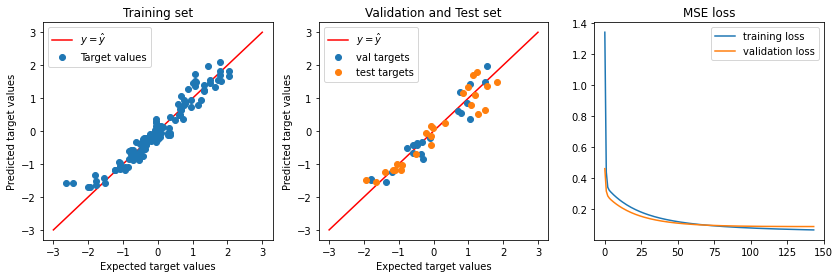

In [6]:
import torch.nn as nn
class ANRegressor(nn.Module):
    def __init__(self):
        super(ANRegressor, self).__init__()
        self.layer = nn.Linear(86, 1)

    def forward(self, x):
        x = self.layer(x)      
        return x

# create network
net = ANRegressor()
print(net)

# mean squared error loss
loss_function = nn.MSELoss()

# stochastic gradient descent optimiser
optimizer = torch.optim.SGD(net.parameters(), lr=0.005)

# train
train_losses=[]
val_losses=[]
for i in range(1000):
    loss = train(net, X_train, y_train)
    train_losses.append(loss) # we save losses to display them at the end
    val_losses.append(validate(net,X_val,y_val))

    if(i>1):
        if val_losses[i-1]>val_losses[i-2]:
            print('Final iteration: ', i)
            break

# calculate training and test performance 
rmse_train = RMSE(net,X_train,y_train)
print('Training RMSE: ', rmse_train)
rmse_val = RMSE(net,X_val,y_val)
print('Validation RMSE: ', rmse_val)
rmse_test = RMSE(net,X_test,y_test)
print('Test RMSE: ', rmse_test)

# display results
plt.figure(figsize=(14,4))

# plot training set predictions
plt.subplot(131)
PlotTargets(net(X_train).data,y_train)
plt.title('Training set')

# plot validation and test set predictions
plt.subplot(132)
PlotTargets(net(X_val).data, y_val, label = 'val targets')
PlotTargets(net(X_test).data,y_test, label = 'test targets', plot_line=False)
plt.title('Validation and Test set')

# plot training and validation loss
plt.subplot(133)
plt.plot(train_losses,label='training loss')
plt.plot(val_losses,label='validation loss')
plt.title('MSE loss')
plt.legend()

## Exercise 5 (optional)

Do this exercise if you finished early and have time to play with a more complex neural network. We will now tune a multi-layer perceptron to predict age from 6 brain volumes. 

First, we will load the dataset with 6 brain structures. Note that the code below will overwrite the previous dataset.

**Task 5.1:** Fill in the missing code to convert the feature matrix and target vector from numpy arrays to a format suitable for training in Pytorch.

In [7]:
# only do this if you work on Google Colab
# run the cell
# then upload file 'GA-brain-volumes-6-features.csv'

#from google.colab import files
#files.upload()

In [8]:
X,y = CreateFeaturesTargets('GA-brain-volumes-6-features.csv')

# perform scaling of the target values to support better convergence
target_scaler = StandardScaler()
y = target_scaler.fit_transform(y)

print('Number of samples is', X.shape[0])
print('Number of features is', X.shape[1])

# convert to tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X type: ', X.type())
print('y type: ', y.type())

Number of samples is 164
Number of features is 6
X shape:  torch.Size([164, 6])
y shape:  torch.Size([164, 1])
X type:  torch.FloatTensor
y type:  torch.FloatTensor


**Task 5.2:** Create training, validation and test set similarly to exercise 4.

In [9]:
# extract test set
groups = np.round(y/3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=groups)

# extract validation set 
groups_val = np.round(y_train/3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=groups_val)

# display info
print('Training samples: ', y_train.shape[0])
print('Validation samples: ', y_val.shape[0])
print('Test samples: ', y_test.shape[0])

Training samples:  118
Validation samples:  21
Test samples:  25


**Task 5.3:** Perform training and evaluation of the performance using the same code as you developed in Exercise 4. You need to adapt the architecture to take 6 input features, but other than that the code should work. Adjust the learning rate to achieve optimal performance.

**Task 5.4:** Implement a multi-layer perceptron architecture as follows:
* First `Linear` layer with 6 outputs
* `ReLU` activation
* Second `Linear` layer with 6 inputs and 1 output

See whether you can achieve better performance with this non-linear network.

ANRegressor(
  (layer): Linear(in_features=6, out_features=6, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=6, out_features=1, bias=True)
)
Final iteration:  292
Training RMSE:  0.72
Validation RMSE:  0.79
Test RMSE:  0.85


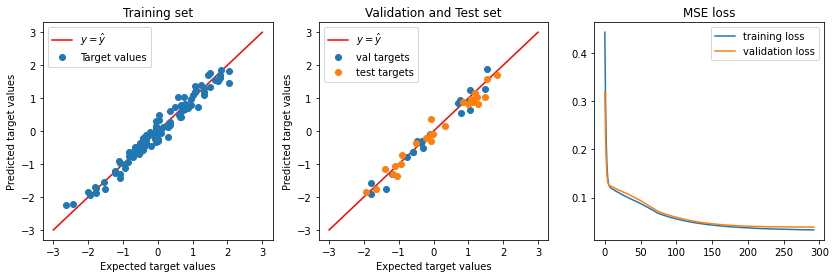

In [10]:
import torch.nn as nn
class ANRegressor(nn.Module):
    def __init__(self):
        super(ANRegressor, self).__init__()
        self.layer = nn.Linear(6, 6)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(6,1)

    def forward(self, x):
        x = self.layer(x)    
        x = self.relu(x) 
        x = self.layer2(x) 
        return x

# create network
net = ANRegressor()
print(net)

# mean squared error loss
loss_function = nn.MSELoss()

# stochastic gradient descent optimiser
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# train
train_losses=[]
val_losses=[]

for i in range(1000):
    loss = train(net, X_train, y_train)
    train_losses.append(loss) # we save losses to display them at the end
    val_losses.append(validate(net,X_val,y_val))

    if(i>1):
        if val_losses[i-1]>val_losses[i-2]:
            print('Final iteration: ', i)
            break

# calculate training and test performance 
rmse_train = RMSE(net,X_train,y_train)
print('Training RMSE: ', rmse_train)
rmse_val = RMSE(net,X_val,y_val)
print('Validation RMSE: ', rmse_val)
rmse_test = RMSE(net,X_test,y_test)
print('Test RMSE: ', rmse_test)

# display results
plt.figure(figsize=(14,4))

# plot training set predictions
plt.subplot(131)
PlotTargets(net(X_train).data,y_train)
plt.title('Training set')

# plot validation and test set predictions
plt.subplot(132)
PlotTargets(net(X_val).data, y_val, label = 'val targets')
PlotTargets(net(X_test).data,y_test, label = 'test targets', plot_line=False)
plt.title('Validation and Test set')

# plot training and validation loss
plt.subplot(133)
plt.plot(train_losses,label='training loss')
plt.plot(val_losses,label='validation loss')
plt.title('MSE loss')
plt.legend()